# Busqueda Visual

## 1. Dataset

In [1]:
! mkdir ~/.kaggle
! cp drive/MyDrive/kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download agrigorev/clothing-dataset-full

100% 6.50G/6.50G [00:58<00:00, 142MB/s]
100% 6.50G/6.50G [00:58<00:00, 119MB/s]


In [3]:
! unzip clothing-dataset-full

Streaming output truncated to the last 5000 lines.
  inflating: images_original/2126322b-b4eb-4410-988a-9261155c017a.jpg  
  inflating: images_original/2135ff47-f57e-4252-8fb8-5f89f1f757c4.jpg  
  inflating: images_original/214245bb-8308-4981-be30-4f82e4766607.jpg  
  inflating: images_original/2153199f-0a48-4334-bb12-51e07486b5c0.jpg  
  inflating: images_original/21531a69-d7f0-4d77-a2d9-a4269652344e.jpg  
  inflating: images_original/215d49b8-c7b7-4ce0-979c-9f9edf1065d7.jpg  
  inflating: images_original/2160a577-406a-4812-ada2-2a3cb30c2ba8.jpg  
  inflating: images_original/216ddb53-2a80-4218-99b0-b5b721744fc3.jpg  
  inflating: images_original/216f2433-a511-4834-9b8c-d01bc926d5d4.jpg  
  inflating: images_original/2174d585-e8cf-43ce-bb61-de1567c74fd5.jpg  
  inflating: images_original/21845140-b1e3-4344-b836-60e1d4b09311.jpg  
  inflating: images_original/2199f7e3-4474-4ebc-aeff-4da50d2e49d5.jpg  
  inflating: images_original/21a06a8f-583d-40c5-b5f8-2b735af0f8e5.jpg  
  inflating: 

In [4]:
! rm clothing-dataset-full.zip

## 2. Preprocesamiento

In [5]:
import pandas as pd
import os
import shutil

In [6]:
csv_path = 'images.csv'
csv = pd.read_csv(csv_path)
csv.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [7]:
csv.shape

(5403, 4)

In [8]:
# Contar las clases
labels = csv.label.value_counts()
labels

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

In [9]:
labels = labels[labels>=100]
print(labels)

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Name: label, dtype: int64


In [10]:
labels = list(labels.index)

In [11]:
# Eliminamos las clases con pocos elementos
csv2 = csv[csv['label'].isin(labels)]

In [12]:
csv2.shape

(5189, 4)

Creamos las carpetas

In [13]:
base_path = './data/'
train_path = base_path + 'train/'
test_path = base_path + 'test/'

In [14]:
for label in labels:
  os.makedirs(train_path + label)
  os.makedirs(test_path + label)

Completar los elementos

In [15]:
val_dict = {x:50 for x in labels}

In [16]:
for index,row in csv2.iterrows():
  img_name = row['image']
  label = row['label']
  last_path = './images_compressed/' + img_name + '.jpg'
  if val_dict[label]>0:
    val_dict[label] -= 1
    new_path = test_path + label + '/' + str(index) + '.jpg' 
  else:
    new_path = train_path + label + '/' + str(index) + '.jpg' 
  try:
    shutil.copy(last_path,new_path)
  except:
    print(img_name, 'no se pudo copiar')

## 3. Modelo 

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers, applications, callbacks
from tensorflow.keras.preprocessing import image

In [18]:
feat_model = applications.MobileNet(input_shape=(224,224,3), include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [19]:
feat_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [20]:
for layer in feat_model.layers:
  layer.trainable = False

In [21]:
# Modelo para clasificar
input1 = layers.Input(shape=(7,7,1024))
flatt1 = layers.GlobalAveragePooling2D()(input1)
dense1 = layers.Dense(units=256, activation='relu')(flatt1)
dense2 = layers.Dense(units=256, activation='relu')(dense1)
dense3 = layers.Dense(units=15, activation='softmax')(dense2)

In [22]:
class_model = tf.keras.Model(inputs=input1, outputs=dense3)

In [23]:
class_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 1024)]      0         
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 15)                3855      
                                                                 
Total params: 332,047
Trainable params: 332,047
Non-trainable params: 0
_______________________________________________________

In [24]:
# Mezcla de los modelos
input_final = layers.Input(shape=(224,224,3));
output_feat = feat_model(input_final)
output_clas = class_model(output_feat)

In [25]:
# Creamos el modelo final
final_model = tf.keras.Model(inputs=input_final, outputs=output_clas)

In [26]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 model (Functional)          (None, 15)                332047    
                                                                 
Total params: 3,560,911
Trainable params: 332,047
Non-trainable params: 3,228,864
_________________________________________________________________


In [27]:
# Compilamos
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [28]:
# Callbacks
cb1 = callbacks.EarlyStopping(patience=4, restore_best_weights=True)

## 4. Generador de imagenes

In [29]:
generator = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.1,
    horizontal_flip = True,
    zoom_range = 0.1,
    preprocessing_function = applications.mobilenet.preprocess_input
)

In [30]:
train_data = generator.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 64
)
val_data = generator.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 64
)

Found 4439 images belonging to 15 classes.
Found 750 images belonging to 15 classes.


## 5. Entrenamiento

In [34]:
history = final_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
70/70 [==============================] - 70s 995ms/step - loss: 2.3511 - acc: 0.2298 - val_loss: 3.1337 - val_acc: 0.0787
Epoch 2/10
70/70 [==============================] - 75s 1s/step - loss: 2.2838 - acc: 0.2760 - val_loss: 2.9887 - val_acc: 0.0987
Epoch 3/10
70/70 [==============================] - 67s 963ms/step - loss: 2.1800 - acc: 0.3161 - val_loss: 2.9238 - val_acc: 0.1400
Epoch 4/10
70/70 [==============================] - 69s 988ms/step - loss: 2.0945 - acc: 0.3476 - val_loss: 2.9166 - val_acc: 0.1267
Epoch 5/10
70/70 [==============================] - 70s 995ms/step - loss: 2.0312 - acc: 0.3733 - val_loss: 2.9270 - val_acc: 0.1453
Epoch 6/10
70/70 [==============================] - 67s 959ms/step - loss: 1.9720 - acc: 0.3940 - val_loss: 2.9743 - val_acc: 0.1453
Epoch 7/10
70/70 [==============================] - 67s 955ms/step - loss: 1.9016 - acc: 0.4190 - val_loss: 2.9302 - val_acc: 0.1640
Epoch 8/10
70/70 [==============================] - 68s 971ms/step - los

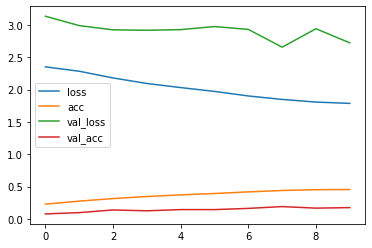

In [36]:
pd.DataFrame(history.history).plot()

## 6. Exportar modelo e imagenes

In [37]:
# Modelo
class_model.save('class_model.h5')

In [33]:
! mkdir -p drive/MyDrive/clases/datasets/cloth/data/
! cp -r ./data drive/MyDrive/clases/datasets/cloth/data/

In [38]:
! cp class_model.h5 drive/MyDrive/clases/datasets/cloth/data/class_model.h5